# Model 2: Mel Spectrogram

## Extracting the data

In [1]:
import os

ravdess_directory_list = os.listdir("dataset")

file_emotion = []
file_path = []
for i in ravdess_directory_list:
    actor = os.listdir("dataset/" + i)
    for f in actor:
        part = f.split('.')[0].split('-')
        file_emotion.append(int(part[2]))
        file_path.append("dataset/" + i + '/' + f)


## We use the mel-spectrogram of the audio for our training - 2-dimensional CNN

Example:

In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

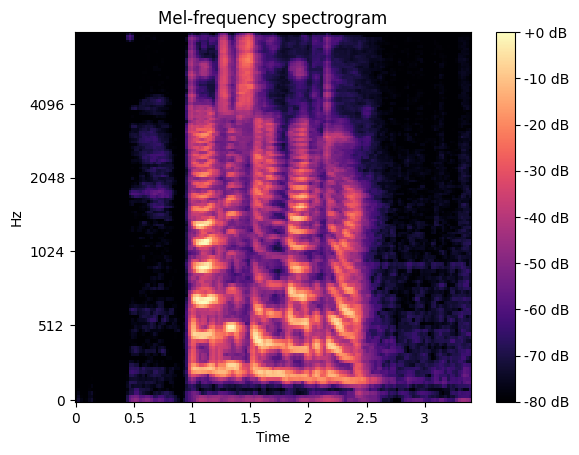

In [3]:
data, sampling_rate = librosa.load('dataset/Actor_06/03-01-01-01-02-01-06.wav')
S = librosa.feature.melspectrogram(y=data, sr=sampling_rate)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sampling_rate, fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')
plt.show()

In [4]:
# creating the mel-spectrogram for all audio files

def create_mel_spectrogram(file_path):
    y, sr = librosa.load(file_path, duration=3)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB

mel_spectrograms = []
for i in file_path:
    mel_spectrograms.append(create_mel_spectrogram(i))

In [5]:
# the list contains some spectrograms which have irregular shapes, so we remove them and their corresponding emotion labels

mismatched_indices = [i for i in range(len(mel_spectrograms)) if mel_spectrograms[i].shape != (128, 130)]
filtered_emotions = [i for j, i in enumerate(file_emotion) if j not in mismatched_indices]
filtered_mel_spectrogram = [i for i in mel_spectrograms if i.shape == (128, 130)]
len(filtered_mel_spectrogram)


1438

In [6]:
# applying standardization

mel_spectrograms =  np.array(filtered_mel_spectrogram)
mel_spectrograms = mel_spectrograms.reshape(mel_spectrograms.shape[0], 128, 130, 1)

mean = np.mean(mel_spectrograms)
std = np.std(mel_spectrograms)
mel_spectrograms = (mel_spectrograms - mean) / std

### Model building and training

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


In [8]:
# splitting hte data into training and testing

X = mel_spectrograms
y = np.array(filtered_emotions)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

In [9]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

torch.Size([1150, 128, 130, 1]) torch.Size([1150]) torch.Size([288, 128, 130, 1]) torch.Size([288])


In [10]:
# reshaping the data so that model recognizes that it is a single-channeled image

X_train = X_train.reshape(X_train.shape[0], 1, 128, 130)
X_test = X_test.reshape(X_test.shape[0], 1, 128, 130)

In [11]:
# making sure the y labels are  zero-indexed
y_train = y_train - 1
y_test = y_test - 1

In [12]:
# using gpu if available

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [13]:
# building the model

class CNN(nn.Module):
    def __init__(self):
            super().__init__()
            self.network = nn.Sequential(
                
                nn.Conv2d(1, 32, kernel_size = 3, padding = 1),
                nn.ReLU(),
                nn.MaxPool2d(2,2),
                nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
                nn.ReLU(),
                nn.MaxPool2d(2,2),
                nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
                nn.ReLU(),
                nn.MaxPool2d(2,2),
                
                nn.Flatten(),
                nn.Linear(32768,1024),
                nn.ReLU(),
                nn.Linear(1024, 512),
                nn.ReLU(),
                nn.Linear(512, 8)
            )
        
    def forward(self, x):
        return self.network(x)
    
model = CNN()
model = model.to(device)
print(model)

CNN(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=32768, out_features=1024, bias=True)
    (11): ReLU()
    (12): Linear(in_features=1024, out_features=512, bias=True)
    (13): ReLU()
    (14): Linear(in_features=512, out_features=8, bias=True)
  )
)


In [14]:
def create_data_loader(train_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size)
    return train_dataloader

In [15]:
# training

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 40
batch_size = 32

train_data = TensorDataset(X_train, y_train)
train_loader = create_data_loader(train_data, batch_size)

In [16]:
torch.cuda.empty_cache()

In [17]:
from tqdm import tqdm

for e in range(epochs):
    running_loss = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        print(f"Epoch [{e+1}] Training loss: {running_loss/len(train_loader)}")

  0%|          | 0/36 [00:00<?, ?it/s]/home/shail/Projects/Speech_emotion_recognition/env/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 36/36 [00:01<00:00, 22.93it/s]


Epoch [1] Training loss: 2.120991610818439


100%|██████████| 36/36 [00:01<00:00, 24.98it/s]


Epoch [2] Training loss: 1.826323926448822


100%|██████████| 36/36 [00:01<00:00, 25.00it/s]


Epoch [3] Training loss: 1.6051265895366669


100%|██████████| 36/36 [00:01<00:00, 24.93it/s]


Epoch [4] Training loss: 1.3709014024999406


100%|██████████| 36/36 [00:01<00:00, 24.87it/s]


Epoch [5] Training loss: 1.1127371307876375


100%|██████████| 36/36 [00:01<00:00, 24.94it/s]


Epoch [6] Training loss: 0.8557939413521025


100%|██████████| 36/36 [00:01<00:00, 24.97it/s]


Epoch [7] Training loss: 0.7750967856910493


100%|██████████| 36/36 [00:01<00:00, 24.88it/s]


Epoch [8] Training loss: 0.6808898283375634


100%|██████████| 36/36 [00:01<00:00, 24.93it/s]


Epoch [9] Training loss: 0.4852835134499603


100%|██████████| 36/36 [00:01<00:00, 24.97it/s]


Epoch [10] Training loss: 0.3114332376668851


100%|██████████| 36/36 [00:01<00:00, 24.97it/s]


Epoch [11] Training loss: 0.2577206264767382


100%|██████████| 36/36 [00:01<00:00, 24.98it/s]


Epoch [12] Training loss: 0.11534884380590585


100%|██████████| 36/36 [00:01<00:00, 24.87it/s]


Epoch [13] Training loss: 0.07299729866079158


100%|██████████| 36/36 [00:01<00:00, 24.93it/s]


Epoch [14] Training loss: 0.03238634758680645


100%|██████████| 36/36 [00:01<00:00, 24.81it/s]


Epoch [15] Training loss: 0.011815901680771882


100%|██████████| 36/36 [00:01<00:00, 24.99it/s]


Epoch [16] Training loss: 0.014759127642416084


100%|██████████| 36/36 [00:01<00:00, 24.95it/s]


Epoch [17] Training loss: 0.04022258365067602


100%|██████████| 36/36 [00:01<00:00, 25.03it/s]


Epoch [18] Training loss: 0.01520392245018027


100%|██████████| 36/36 [00:01<00:00, 24.83it/s]


Epoch [19] Training loss: 0.011723409895138402


100%|██████████| 36/36 [00:01<00:00, 24.88it/s]


Epoch [20] Training loss: 0.0025156970712285126


100%|██████████| 36/36 [00:01<00:00, 24.85it/s]


Epoch [21] Training loss: 0.0010611480344474937


100%|██████████| 36/36 [00:01<00:00, 24.90it/s]


Epoch [22] Training loss: 0.0003307925095820489


100%|██████████| 36/36 [00:01<00:00, 24.92it/s]


Epoch [23] Training loss: 0.0002440788773835973


100%|██████████| 36/36 [00:01<00:00, 24.87it/s]


Epoch [24] Training loss: 0.00019604486705146782


100%|██████████| 36/36 [00:01<00:00, 24.92it/s]


Epoch [25] Training loss: 0.00016315550722841485


100%|██████████| 36/36 [00:01<00:00, 24.87it/s]


Epoch [26] Training loss: 0.00013897158027652444


100%|██████████| 36/36 [00:01<00:00, 24.88it/s]


Epoch [27] Training loss: 0.00012027859742779078


100%|██████████| 36/36 [00:01<00:00, 24.91it/s]


Epoch [28] Training loss: 0.00010540747229646918


100%|██████████| 36/36 [00:01<00:00, 24.93it/s]


Epoch [29] Training loss: 9.333656225862796e-05


100%|██████████| 36/36 [00:01<00:00, 24.91it/s]


Epoch [30] Training loss: 8.319269151494761e-05


100%|██████████| 36/36 [00:01<00:00, 24.95it/s]


Epoch [31] Training loss: 7.467826945786428e-05


100%|██████████| 36/36 [00:01<00:00, 24.93it/s]


Epoch [32] Training loss: 6.742707975920186e-05


100%|██████████| 36/36 [00:01<00:00, 24.95it/s]


Epoch [33] Training loss: 6.112201900678984e-05


100%|██████████| 36/36 [00:01<00:00, 25.02it/s]


Epoch [34] Training loss: 5.5771369514129925e-05


100%|██████████| 36/36 [00:01<00:00, 24.96it/s]


Epoch [35] Training loss: 5.105164387310247e-05


100%|██████████| 36/36 [00:01<00:00, 24.88it/s]


Epoch [36] Training loss: 4.6976272364594886e-05


100%|██████████| 36/36 [00:01<00:00, 24.94it/s]


Epoch [37] Training loss: 4.335139998248552e-05


100%|██████████| 36/36 [00:01<00:00, 24.88it/s]


Epoch [38] Training loss: 4.016851188579393e-05


100%|██████████| 36/36 [00:01<00:00, 24.89it/s]


Epoch [39] Training loss: 3.732375312716208e-05


100%|██████████| 36/36 [00:01<00:00, 24.89it/s]

Epoch [40] Training loss: 3.469983443614587e-05


In [18]:
test_data = TensorDataset(X_test, y_test)
test_loader = create_data_loader(test_data, batch_size)

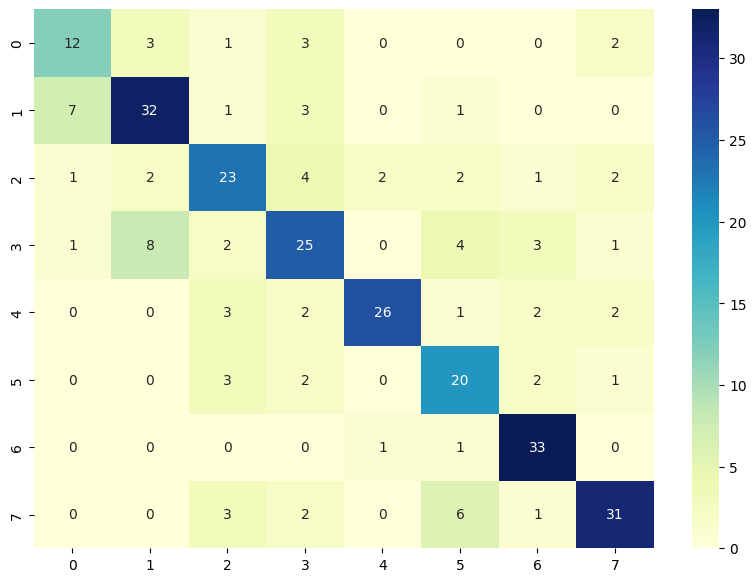

In [19]:
# confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

y_pred = []
y_true = []

with torch.no_grad():
    model.eval()
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in range(8)], columns = [i for i in range(8)])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")
plt.show()


In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.57      0.57        21
           1       0.71      0.73      0.72        44
           2       0.64      0.62      0.63        37
           3       0.61      0.57      0.59        44
           4       0.90      0.72      0.80        36
           5       0.57      0.71      0.63        28
           6       0.79      0.94      0.86        35
           7       0.79      0.72      0.76        43

    accuracy                           0.70       288
   macro avg       0.70      0.70      0.69       288
weighted avg       0.71      0.70      0.70       288



## We achieve an accuracy of 70% from training a 2D CNN on the mel-spectrograms of the audio.